<a href="https://colab.research.google.com/drive/1AZ322pQYdCMNX5WR34u8CFr7cVdjLu00" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Learning Goals

1. **Understand Encoder and Decoder Models**: Get familiar with both types of models and how they work in text analytics.
2. **Model Selection**: Learn how to choose the right model for a specific task.
3. **Apply Few-Shot Learning**: Use few-shot learning techniques to enhance model performance.
4. **Evaluate Models**: Use metrics like accuracy and F1-score to assess model effectiveness.
5. **Compare Models**: Learn how to draw comparisons between different models based on evaluation metrics.

# Introduction

The goal of this project is to explore and understand the capabilities of different language models, specifically focusing on encoder and decoder architectures.

## Dataset

We will use the Financial Phrasebank dataset, which consists of sentences from English language financial news categorized by sentiment. This dataset provides a real-world scenario for us to test and evaluate the selected models.


# Setup


In [ ]:
!pip install transformers datasets --quiet
!pip install scikit-learn --quiet
!pip install openai --quiet
!pip install einops --quiet
!pip install python-dotenv --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which

In [ ]:
from datasets import get_dataset_config_names, load_dataset
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import random
from typing import List, Dict, Any, Union, Generator, Callable
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
import openai
from getpass import getpass
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
import unittest
from unittest.mock import Mock

torch_device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(torch_device)

# Data Exploration

## Dataset Overview

We'll use the Financial Phrasebank dataset for this project. This dataset contains sentences extracted from financial news articles, each labeled with a sentiment category. The dataset serves as a real-world testbed for evaluating the performance of various language models in the domain of financial text analytics.

## Loading the Dataset

We'll be using the Financial Phrasebank dataset available on Hugging Face. This dataset comes with a few different configurations based on the agreement rate among annotators. The configurations available are:

- `sentences_allagree`
- `sentences_75agree`
- `sentences_66agree`
- `sentences_50agree`

For this project, we'll use the `sentences_50agree` configuration.

## Splitting Data

The dataset from Hugging Face doesn't come pre-split into training and test sets; it only has a 'train' split. Therefore, we'll need to create our own test set.

In [ ]:
# List available configurations
configs = get_dataset_config_names("financial_phrasebank")

# Load the dataset with the 'sentences_50agree' configuration
phrasebank = load_dataset("financial_phrasebank", "sentences_50agree")

# Split the 'train' data into training and test sets
phrasebank_split = phrasebank["train"].train_test_split(test_size=0.1, shuffle=True)

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

## Basic Statistics

Let's get a quick sense of the data size and structure. Specifically, the number of samples and the distribution of sentiment labels.  The labels are 0, 1, and 2 for negative, neutral, and positive.

We are working with pre-trained models, which means we won't be using the training set to update the model weights through training, but for one-shot or few-shot learning. This approach allows us to leverage a small subset of labeled examples to guide the model's predictions. We will then evaluate how these adjustments impact the model's performance on the test set.

Number of samples in training set: 4361
Number of samples in test set: 485


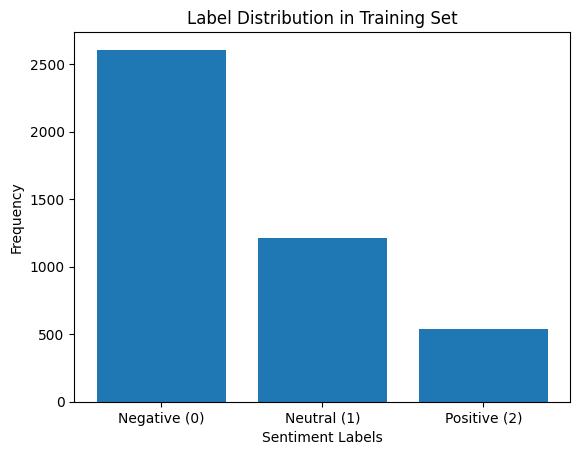

In [ ]:
# Count the number of samples in the training set
num_samples_train = len(phrasebank_split['train'])
# Count the number of samples in the test set
num_samples_test = len(phrasebank_split['test'])

# Display basic statistics
print(f"Number of samples in training set: {num_samples_train}")
print(f"Number of samples in test set: {num_samples_test}")

# Extract labels from the training set and count occurrences
label_list = [example['label'] for example in phrasebank_split['train']]
label_counts = Counter(label_list)
# Create the histogram
labels, counts = zip(*label_counts.items())

# 0 = 'negative', 1 = 'neutral', 2 = 'positive'
label_names = ['Negative (0)', 'Neutral (1)', 'Positive (2)']
plt.bar(label_names, counts)
plt.xlabel('Sentiment Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution in Training Set')
plt.show()

## Sample Data

Let's take a quick look at the data.

In [ ]:
# Randomly pick 5 samples from the training set
random_samples = random.choices(phrasebank_split['train'], k=5)

# Display the samples
for i, sample in enumerate(random_samples,1):
    print(f"Sample {i}:")
    print(f"Text: {sample['sentence']}")
    print(f"Label: {sample['label']} (0: Negative, 1: Neutral, 2: Positive)")
    print("---")


Sample 1:
Text: Nordea Bank ( STO : NDA ) and Sampo Bank have helped Finnish real estate investment company Sponda ( HEL : SDA1V ) place a EUR100m ( USD125 .4 m ) domestic bond , the company said Friday .
Label: 2 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 2:
Text: Both operating profit and net sales for the three-month period increased , respectively from EUR15 .1 m and EUR131 .5 m , as compared to the corresponding period in 2005 .
Label: 2 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 3:
Text: The operating profit for Grain Trading increased to EUR 2.0 mn from EUR 1.4 mn in 2005 .
Label: 2 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 4:
Text: Samsung currently occupies third place and lost ground during the quarter , dropping by 1.8 % to an 11.1 % share overall .
Label: 0 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 5:
Text: Nordic banks have already had to write off sizable loans in Latvia , with Swedbank , Nordea , DnB NOR and SEB reporting combined losses in 

# Few-Shot Learning

Few-shot learning is pivotal for flexing the capabilities of decoder models like Phi-1.5 and ChatGPT. In contrast to encoder models, which are highly specialized but not very adaptable, few-shot learning allows decoder models to perform different tasks without requiring any retraining.

Let's write a python generator to prepare few-shot examples on the fly. These examples will come from the training set and will "prime" the models to perform sentiment analysis on the test set. Essentially, we'll use a handful of examples to guide the model's understanding of what 'Negative,' 'Neutral,' and 'Positive' sentiments look like.

Example format:

```text
Classify the sentiment (negative, neutral, positive) of the following statement:
[This is a negative sample from the phrasebank.]
Reponse: negative
```
For the test phrase "Export declined by 6 percent to 16.4 million liters", a zero shot example would look like:
```text
Classify the sentiment (negative, neutral, positive) of the following statement:
[Export declined by 6 percent to 16.4 million liters]
Reponse:
```
A one-shot example would look like:
```text
Classify the sentiment (negative, neutral, positive) of the following statement:
[Finnish Raisio ( Diagnostics ) is launching new DNA-based quick tests to ensure the safety of food .]
Reponse: positive
[Export declined by 6 percent to 16.4 million liters]
Reponse:
```
A two-shot example would look like:
```text
Classify the sentiment (negative, neutral, positive) of the following statement:
[Finnish meat company Atria can no longer promise a sufficient amount of domestic beef to its customers .]
Reponse: negative
[Finnish Raisio ( Diagnostics ) is launching new DNA-based quick tests to ensure the safety of food .]
Reponse: positive
[Export declined by 6 percent to 16.4 million liters]
Reponse:
```


In [ ]:
def generate_n_shot_examples(prompt: str,
                             train_set: List[Dict[str, Any]],
                             test_set: List[Dict[str, Any]],
                             n: int) -> Generator[str, None, None]:  # returns nothing when exhausted
    """
    Generates simple n-shot examples using sequential samples from the training set.

    This function selects the next 'n' examples from the training set and appends them
    to each query from the test set to create n-shot learning examples.

    Args:
        prompt: The prompt text to be used for the few-shot examples.
        train_set: The training set, a list of dictionaries containing 'sentence' and 'label' keys.
        test_set: The test set, a list of dictionaries containing 'sentence' and 'label' keys.
        n: The number of examples to select from the training set.

    Yields:
        A sample, label representing an n-shot example.
    """

    sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}

    # how many samples (batches of n examples) can we create?
    if n != 0 and len(train_set) >= n:
        # we can create batches of n examples, at least once
        # for every test set examples, but maybe we don't have
        # enough train examples
        n_samples = min(len(test_set), len(train_set) // n)
    else:
        # if n = 0 or len(train_set) < n, then we cant make enough / dont
        # want examples, so we pick the test set one by one
        n_samples = len(test_set)

    test_gen = iter(test_set)
    train_gen = iter(train_set)

    # Generate n-shot examples
    for _ in range(n_samples):
        test_sample = next(test_gen)
        n_shot_example = f"{prompt}:\n"  # prompt comes first, once, before the examplles

        # now add n-shot examples to the prompt
        for _ in range(n):
            train_sample = next(train_gen)
            n_shot_example += f"[{train_sample['sentence']}]\nResponse: {sentiment_labels[train_sample['label']]}\n"

        # Final test sentence without its label
        n_shot_example += f"[{test_sample['sentence']}]\nResponse:"

        # Use the sentiment_labels dict to convert the numeric (0,1,2) to a text label
        sentiment_label = sentiment_labels[test_sample['label']]

        yield n_shot_example, sentiment_label



In [ ]:
# Generate 2-shot examples
n_shot_generator = generate_n_shot_examples("Classify the sentiment (negative, neutral, positive) of the following statement",
                                            phrasebank_split['train'], phrasebank_split['test'], 2)

for _ in range(2):
    sample = next(n_shot_generator)
    print(sample[0])
    print()
    print(sample[1])
    print()

Classify the sentiment (negative, neutral, positive) of the following statement:
[After buying Eukor Car Carriers 50 percent stake , Grimaldi Group is now the sole owner of the Swedish roll-on , roll-off port of Wallhamn .]
Response: neutral
[Our strong company brands - ESL Shipping , Leipurin , Telko and Kaukomarkkinat - aim to be the market leaders in their sectors .]
Response: positive
[The item included restructuring costs of EUR1 .6 m , while a year earlier they were EUR13 .1 m. Diluted EPS stood at EUR0 .3 versus a loss per share of EUR 0.1 .]
Response:

positive

Classify the sentiment (negative, neutral, positive) of the following statement:
[The members of the management team will contribute to the adjustment measures with temporary salary cut of 5 % .]
Response: positive
[Country : ; Germany Sector : Construction-Real Estate ; Machinery-Engineering Target : Caverion GmbH Buyer : YIT Oyj Deal size in USD : 90.3 m Type : Corporate acquisition Status : Agreed]
Response: neutral


In [ ]:
# @title Unittests
class TestGenerateNShotExamplesUpdated(unittest.TestCase):

    def test_generate_n_shot_examples(self):
        """
        Test the functionality of generate_n_shot_examples using static data.
        """
        prompt = "Classify the sentiment (negative, neutral, positive) of the following statement"
        train_set: List[Dict[str, Any]] = [
            {'sentence': 'I love this product', 'label': 2},
            {'sentence': 'This is just okay', 'label': 1},
            {'sentence': 'I hate this', 'label': 0},
            {'sentence': 'This is amazing', 'label': 2}
        ]
        test_set: List[Dict[str, Any]] = [
            {'sentence': 'This is terrible', 'label': 0},
            {'sentence': 'This is fantastic', 'label': 2}
        ]
        n = 2

        expected_output = [
            f"{prompt}:\n[I love this product]\nResponse: positive\n[This is just okay]\nResponse: neutral\n[This is terrible]\nResponse:",
            f"{prompt}:\n[I hate this]\nResponse: negative\n[This is amazing]\nResponse: positive\n[This is fantastic]\nResponse:"
        ]
        expected_labels = ['negative', 'positive']

        gen: Generator[str, None, None] = generate_n_shot_examples(prompt, train_set, test_set, n)

        for prompt, label in zip(expected_output, expected_labels):
            produced = next(gen)
            self.assertEqual(produced[0], prompt)
            self.assertEqual(produced[1], label)

        # Test for exhaustion of generator
        with self.assertRaises(StopIteration):
            next(gen)

    def test_small_train_set(self):
        """
        Test the case where the train set is smaller than the test set.
        """
        prompt = "Classify the sentiment"
        train_set: List[Dict[str, Any]] = [
            {'sentence': 'I love this', 'label': 2}
        ]
        test_set: List[Dict[str, Any]] = [
            {'sentence': 'This is bad', 'label': 0},
            {'sentence': 'This is good', 'label': 2}
        ]
        n = 1

        # Since there's only one training example, it should be repeated for each test example.
        expected_output = [
            f"{prompt}:\n[I love this]\nResponse: positive\n[This is bad]\nResponse:",
        ]

        gen: Generator[str, None, None] = generate_n_shot_examples(prompt, train_set, test_set, n)

        for expected in expected_output:
            self.assertEqual(next(gen)[0], expected)

        # Test for exhaustion of generator
        with self.assertRaises(StopIteration):
            next(gen)

    def test_small_test_set(self):
        """
        Test the case where the test set is smaller than the train set.
        """
        prompt = "Classify the sentiment"
        train_set: List[Dict[str, Any]] = [
            {'sentence': 'I love this', 'label': 2},
            {'sentence': 'This is okay', 'label': 1},
            {'sentence': 'I hate this', 'label': 0}
        ]
        test_set: List[Dict[str, Any]] = [
            {'sentence': 'This is bad', 'label': 0}
        ]
        n = 2

        expected_output = [
            f"{prompt}:\n[I love this]\nResponse: positive\n[This is okay]\nResponse: neutral\n[This is bad]\nResponse:"
        ]

        gen: Generator[str, None, None] = generate_n_shot_examples(prompt, train_set, test_set, n)

        for expected in expected_output:
            self.assertEqual(next(gen)[0], expected)

        # Test for exhaustion of generator
        with self.assertRaises(StopIteration):
            next(gen)

# Run the tests
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestGenerateNShotExamplesUpdated))


...
----------------------------------------------------------------------
Ran 3 tests in 0.005s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

# Model Overview & Initialization

## Why Encoder and Decoder Models?

We focus on two distinct types of language models: encoder models and decoder models. Encoder models like Roberta and FinBERT are highly specialized for tasks like sentiment analysis. They take text input and transform it into a fixed-size vector that captures essential information. While effective for their specialized tasks, they aren't very flexible for others.

Decoder models such as ChatGPT, Falcon or Phi-1.5 are fundamentally designed to generate text. These models can be adapted for various tasks, like sentiment analysis, through a technique known as few-shot learning. This makes them versatile, even without task-specific training.

By exploring both encoder and decoder models, we will get a well-rounded understanding of their capabilities and constraints. This sets the stage for a comprehensive evaluation later, especially when we change tasks to demonstrate the adaptability of decoder models.

## Running models form different sources

We will execute both open and closed source models:  Roberta, FinBERT, and Phi-1.5 are open source, while GPT-3.5 is closed source and only accessible via API.


## Encoder Inference

First, let's download and run inference on the encoder models. These will include the general-purpose text classification model cardiffnlp/twitter-roberta-base-sentiment-latest and the financial news-focused model ProsusAI/finbert.

In [ ]:
sentiment_names = phrasebank["train"].features["label"].names

# Initialize Roberta tokenizer and model
checkpoint = "cardiffnlp/twitter-roberta-base-sentiment-latest"
roberta_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
roberta_config = AutoConfig.from_pretrained(checkpoint)
roberta_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# Initialize the Finbert tokenizer and model
checkpoint = "ProsusAI/finbert"
finbert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
finbert_config = AutoConfig.from_pretrained(checkpoint)
finbert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sentiment = ['negative', 'neutral', 'positive']

# Run inference on a positive example
text = "Revenue grew 12 percent to (  x20ac ) 3.6 billion ( US$ 4.5 billion ) ."
finbert_inputs = finbert_tokenizer(text, return_tensors="pt")
finbert_outputs = finbert_model(**finbert_inputs)
finbert_prediction = finbert_outputs.logits.argmax(dim=1).item()
finbert_sentiment = finbert_config.id2label[finbert_prediction]

roberta_inputs = roberta_tokenizer(text, return_tensors="pt")
roberta_outputs = roberta_model(**roberta_inputs)
roberta_prediction = roberta_outputs.logits.argmax(dim=1).item()
roberta_sentiment = roberta_config.id2label[roberta_prediction]

print(text)
print(f"Finbert Sentiment Prediction: {finbert_sentiment} ({sentiment_names.index(finbert_sentiment)})")
print(f"Roberta Sentiment Prediction: {roberta_sentiment} ({sentiment_names.index(roberta_sentiment)})")

Revenue grew 12 percent to (  x20ac ) 3.6 billion ( US$ 4.5 billion ) .
Finbert Sentiment Prediction: positive (2)
Roberta Sentiment Prediction: positive (2)


In [ ]:
finbert_inputs

{'input_ids': tensor([[  101,  6599,  3473,  2260,  3867,  2000,  1006,  1060, 11387,  6305,
          1007,  1017,  1012,  1020,  4551,  1006,  2149,  1002,  1018,  1012,
          1019,  4551,  1007,  1012,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0')}

In [ ]:
finbert_outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.1029, -2.0202, -1.4428]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
sentiment_names

['negative', 'neutral', 'positive']

Let's make this a more generic inference function so we can run it in a generic inference loop later.

In [ ]:
def generate_encoder_infer(model_name: str, sent_names: List[str] = sentiment_names) -> Callable[[str], int]:
    """
    Generates a model_infer function for a given encoder model.

    Args:
        model_name: The name of the model to use for inference.

    Returns:
        A model_infer function that takes a sentence as input and returns a predicted label as an integer.
    """
    # model initialization
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    def model_infer(text: str) -> int:
        """
        Runs inference on a encoder model and classifies the classification of a given text.

        Args:
            text: The sentence to classify.

        Returns:
            The predicted label as an integer.
        """

        # inference
        inputs = tokenizer(text, return_tensors="pt")
        outputs = model(**inputs)
        prediction = outputs.logits.argmax(dim=1).item()
        sentiment = config.id2label[prediction]

        # For the sentiment index associated with this sentiment
        # we don't just use the argmax over the output logits
        # because the model might use different indices for its labels.
        sentiment_index = sent_names.index(sentiment)

        return sentiment_index

    return model_infer

finbert_infer = generate_encoder_infer("ProsusAI/finbert", sentiment_names)
roberta_infer = generate_encoder_infer("cardiffnlp/twitter-roberta-base-sentiment-latest", sentiment_names)

sentiment_names[roberta_infer('I am happy')]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'positive'

In [ ]:
# @title Unittests
class TestGenerateEncoderInfer(unittest.TestCase):

    def test_generate_encoder_infer_finbert(self):
        """
        Test generate_encoder_infer with a mock for Finbert model.
        """
        model_infer = generate_encoder_infer("ProsusAI/finbert")

        # Mocked behavior for this test
        text = "Revenue grew 12 percent to (  x20ac ) 3.6 billion ( US$ 4.5 billion ) ."
        expected_output = 2  # 'positive' in the sentiment_names list

        # Running the model inference function
        result = model_infer(text)

        # Assert that the result is as expected
        self.assertEqual(result, expected_output)

    def test_generate_encoder_infer_roberta(self):
        """
        Test generate_encoder_infer with a mock for Roberta model.
        """
        model_infer = generate_encoder_infer("cardiffnlp/twitter-roberta-base-sentiment-latest")

        # Mocked behavior for this test
        text = "Revenue grew 12 percent to (  x20ac ) 3.6 billion ( US$ 4.5 billion ) ."
        expected_output = 2  # 'positive' in the sentiment_names list

        # Running the model inference function
        result = model_infer(text)

        # Assert that the result is as expected
        self.assertEqual(result, expected_output)

# Run the updated tests
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestGenerateEncoderInfer))

.Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
.
----------------------------------------------------------------------
Ran 2 tests in 2.015s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

## Decoder Inference

Let's do the same for the decoder model: Phi-1.5.  First, let's demonstrate the use and versatility of a decoder model.

In [ ]:
# First, load the Tokenizer and Model, just like with FinBert and RoBerta
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- configuration_mixformer_sequential.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- modeling_mixformer_sequential.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Let's show the model's versatility.

In [ ]:
# This is an example from the model card on huggingface: https://huggingface.co/microsoft/phi-1_5
# Note that the model card explains that the model is NOT fine-tuned, so it tends to ramble and
# continue generating text after it answers the question.
# We'll use very basic filtering to extract exactly what we want from the generated output.
inputs = tokenizer('''```python
def print_prime(n):
   """
   Print all primes between 1 and n
   """''', return_tensors="pt", return_attention_mask=False)

outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
start_index = text.find("```python")
end_index = text.find("```", start_index + 3)
generated_code = text[start_index + 9:end_index]

print("This is the code that the model generated:")
print("---------")
print(generated_code)
print("---------")
print("Now, let's execute that code:")
exec(generated_code)

This is the code that the model generated:
---------

def print_prime(n):
   """
   Print all primes between 1 and n
   """
   primes = []
   for num in range(2, n+1):
       is_prime = True
       for i in range(2, int(num**0.5)+1):
           if num % i == 0:
               is_prime = False
               break
       if is_prime:
           primes.append(num)
   print(primes)

print_prime(20)

---------
Now, let's execute that code:
[2, 3, 5, 7, 11, 13, 17, 19]


It's hard to really comprehend how amazing this last code cell is.  This model is reliably generating executable, syntax compliant, python code.  Decoder models have incredible versatility!

Now we're going to ask the same model to do an entirely different task: sentiment analysis using n-shot prompts.

In [ ]:
# zero-shot prompt
zero_shot_generator = generate_n_shot_examples("Classify the sentiment (negative, neutral, positive) of the following statement",
                                               phrasebank_split['train'], phrasebank_split['test'], 0)
zero_shot_sample = next(zero_shot_generator)


zero_shot_prompt, zero_shot_label = zero_shot_sample
# zero_shot_inputs = tokenizer(zero_shot_prompt, return_tensors="pt", return_attention_mask=False)
# input_length = zero_shot_inputs.input_ids.shape[1]
# zero_shot_outputs = model.generate(**zero_shot_inputs, max_new_tokens=20, return_dict_in_generate=True, pad_token_id=tokenizer.eos_token_id)
# zero_shot_output_tokens = zero_shot_outputs.sequences[0, input_length:]
# zero_shot_output_str = tokenizer.decode(zero_shot_output_tokens)

print(zero_shot_prompt)
print('-----------')
print(f'True label: {zero_shot_label}')
print('-----------')
print('(generating...)')
zero_shot_inputs = tokenizer(zero_shot_prompt, return_tensors="pt", return_attention_mask=False)
input_len = zero_shot_inputs.input_ids.shape[1]
zero_shot_outputs = model.generate(**zero_shot_inputs, max_length=200)
zero_shot_output_str = tokenizer.batch_decode(zero_shot_outputs[:,input_len:])[0]
print('-----------')
print(f'Decoder output (cleaned): {zero_shot_output_str.strip().split()[0]}')
print('-----------')
print(f'Decoder output (raw): {zero_shot_output_str}')

Classify the sentiment (negative, neutral, positive) of the following statement:
[The item included restructuring costs of EUR1 .6 m , while a year earlier they were EUR13 .1 m. Diluted EPS stood at EUR0 .3 versus a loss per share of EUR 0.1 .]
Response:
-----------
True label: positive
-----------
(generating...)
-----------
Decoder output (cleaned): Positive
-----------
Decoder output (raw):  Positive

Exercise 2:
Identify the key factors that influenced the company's decision to restructure its debt.
Answer: The key factors that influenced the company's decision to restructure its debt were the need to reduce interest expenses, improve cash flow, and enhance the company's financial position.

Exercise 3:
Explain the concept of dilution in the context of accounting.
Answer: Dilution in accounting refers to the reduction in the value of a company's shares due to the issuance of additional shares. It occurs when the company's earnings are distributed to shareholders in the form of divi

In [ ]:
# one-shot prompt
one_shot_generator = generate_n_shot_examples("Classify the sentiment (negative, neutral, positive) of the following statement",
                                               phrasebank_split['train'], phrasebank_split['test'], 1)
one_shot_sample = next(one_shot_generator)


one_shot_prompt, one_shot_label = one_shot_sample

print(one_shot_prompt)
print('-----------')
print(f'True label: {one_shot_label}')
print('-----------')
print('(generating...)')
one_shot_inputs = tokenizer(one_shot_prompt, return_tensors="pt", return_attention_mask=False)
input_len = one_shot_inputs.input_ids.shape[1]
one_shot_outputs = model.generate(**one_shot_inputs, max_length=200)
one_shot_output_str = tokenizer.batch_decode(one_shot_outputs[:,input_len:])[0]
print('-----------')
print(f'Decoder output (cleaned): {one_shot_output_str.strip().split()[0]}')
print('-----------')
print(f'Decoder output (raw): {one_shot_output_str}')

Classify the sentiment (negative, neutral, positive) of the following statement:
[After buying Eukor Car Carriers 50 percent stake , Grimaldi Group is now the sole owner of the Swedish roll-on , roll-off port of Wallhamn .]
Response: neutral
[The item included restructuring costs of EUR1 .6 m , while a year earlier they were EUR13 .1 m. Diluted EPS stood at EUR0 .3 versus a loss per share of EUR 0.1 .]
Response:
-----------
True label: positive
-----------
(generating...)
-----------
Decoder output (cleaned): neutral
-----------
Decoder output (raw):  neutral
[The company has a strong balance sheet and a solid business model. It is also a well-known brand in the industry.]
Response: neutral
[The company has a strong balance sheet and a solid business model. It is also a well-known brand in the industry.]
Response: neutral
[The company has a strong balance sheet and a solid business model. It is also a well-known brand in the industry.]



In [ ]:
# ten-shot prompt!
ten_shot_generator = generate_n_shot_examples("Classify the sentiment (negative, neutral, positive) of the following statement",
                                               phrasebank_split['train'], phrasebank_split['test'], 10)
ten_shot_sample = next(ten_shot_generator)


ten_shot_prompt, ten_shot_label = ten_shot_sample

print(ten_shot_prompt)
print('-----------')
print(f'True label: {ten_shot_label}')
print('-----------')
print('(generating...)')
ten_shot_inputs = tokenizer(ten_shot_prompt, return_tensors="pt", return_attention_mask=False)
input_len = ten_shot_inputs.input_ids.shape[1]
ten_shot_outputs = model.generate(**ten_shot_inputs, max_length=200)
ten_shot_output_str = tokenizer.batch_decode(ten_shot_outputs[:,input_len:])[0]
print('-----------')
print(f'Decoder output (cleaned): {ten_shot_output_str.strip().split()[0]}')
print('-----------')
print(f'Decoder output (raw): {ten_shot_output_str}')

Classify the sentiment (negative, neutral, positive) of the following statement:
[After buying Eukor Car Carriers 50 percent stake , Grimaldi Group is now the sole owner of the Swedish roll-on , roll-off port of Wallhamn .]
Response: neutral
[Our strong company brands - ESL Shipping , Leipurin , Telko and Kaukomarkkinat - aim to be the market leaders in their sectors .]
Response: positive
[The members of the management team will contribute to the adjustment measures with temporary salary cut of 5 % .]
Response: positive
[Country : ; Germany Sector : Construction-Real Estate ; Machinery-Engineering Target : Caverion GmbH Buyer : YIT Oyj Deal size in USD : 90.3 m Type : Corporate acquisition Status : Agreed]
Response: neutral
[It s an area that is highly valued , because most of the land there has already been built on .]
Response: neutral
[`` BasWare 's product sales grew strongly in the financial period , by 24 percent .]
Response: positive
[Name of Company in which holdings have been 

Now that we've played around a little with Phi-1.5 inference, let'
s build an inference function that is similar to the one we built earlier for the encoder models.

In [ ]:
# we have 4 / 12 GB RAM, 9 / 15 GB GPU at this stage
del model
del finbert_model
del roberta_model
del tokenizer

with torch.cuda.device('cuda:0'):
  torch.cuda.empty_cache()  # Empty CUDA cache to release GPU memory
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

1917936640
2151677952


In [ ]:
def generate_decoder_infer(model_name: str = "microsoft/phi-1_5") -> Callable[[str], int]:
    """
    Generates a model_infer function for a given decoder model.

    Args:
        model_name: The name of the model to use for inference.

    Returns:
        A model_infer function that takes a sentence as input and returns a predicted label as an integer.
    """

    # Initialize the model
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

    def model_infer(text: str, max_new_tokens: int = 20) -> int:
        """
        Runs inference on a decoder model and classifies the classification of a given text.

            Args:
                text: The sentence to classify.

            Returns:
                The "cleaned" output of the decoder.
                (See example cell above.  Specifically, this should return the first complete word generated by the decoder in response to the input text.)
        """

        # Run inference
        inputs = tokenizer(text, return_tensors="pt", return_attention_mask=False)
        input_len = inputs.input_ids.shape[1]
        outputs = model.generate(**inputs, max_length=max_new_tokens)
        output_str = tokenizer.batch_decode(outputs[:,input_len:])[0]
        output_str_cleaned = output_str.strip().split()[0]

        return output_str_cleaned

    return model_infer

decoder_infer = generate_decoder_infer("microsoft/phi-1_5")

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- configuration_mixformer_sequential.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- modeling_mixformer_sequential.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [ ]:
decoder_infer(ten_shot_sample[0], max_new_tokens=200)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 412, but `max_length` is set to 200. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


'positive'

In [ ]:
# @title Unittests
class TestGenerateDecoderInfer(unittest.TestCase):

    def test_generate_decoder_infer_1(self):
        self.assertEqual(decoder_infer("one"), "_hot(labels,")

    def test_generate_decoder_infer_2(self):
        self.assertEqual(decoder_infer("one two"), "-dimensional")

    def test_generate_decoder_infer_3(self):
        self.assertEqual(decoder_infer("one two three four"), "-legged")

# Run the updated tests
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestGenerateDecoderInfer))

...
----------------------------------------------------------------------
Ran 3 tests in 3.568s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

# Encoder evaluation

Now, let's evaluate how well our models do on the dataset!  We'll start with the encoder models because those are simple.  We just infer on each test example and check if the output matches!

In [ ]:
def evaluate_encoder_inference(model_infer: Callable[[str], int], test_dataset: iter) -> dict:
    """
    Evaluate the performance of a model on a test dataset, with progress bar.

    Args:
        model_infer: The model inference function that takes text as input and returns an integer label.
        test_dataset: A generator or iterable containing test samples. Each sample is a dict with keys "label" and "sentence".

    Returns:
        A dictionary containing the average accuracy and F1 score.
    """

    true_labels = []
    predicted_labels = []

    for sample in tqdm(test_dataset, total=len(test_dataset), desc="Evaluating"):

        true_label = sample['label']
        sentence = sample['sentence']

        predicted_label = model_infer(sentence)

        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

    avg_accuracy = accuracy_score(true_labels, predicted_labels)
    avg_f1 = f1_score(true_labels, predicted_labels, average = 'weighted')


    return {'Average Accuracy': avg_accuracy, 'Average F1 Score': avg_f1}

In [ ]:
# @title Unittests
class TestEvaluateEncoderInferenceExtended(unittest.TestCase):

    def test_all_correct_predictions(self):
        """
        Test when all predictions are correct.
        """
        mock_model_infer = Mock()
        mock_model_infer.side_effect = [0, 1, 2, 1, 0]  # All predictions are correct

        mock_test_dataset = [
            {'label': 0, 'sentence': 'This is bad.'},
            {'label': 1, 'sentence': 'This is okay.'},
            {'label': 2, 'sentence': 'This is great.'},
            {'label': 1, 'sentence': 'This is fine.'},
            {'label': 0, 'sentence': 'This is terrible.'}
        ]

        result = evaluate_encoder_inference(mock_model_infer, mock_test_dataset)
        self.assertEqual(result['Average Accuracy'], 1.0)
        self.assertEqual(result['Average F1 Score'], 1.0)

    def test_some_incorrect_predictions(self):
        """
        Test when some predictions are incorrect.
        """
        mock_model_infer = Mock()
        mock_model_infer.side_effect = [0, 1, 0, 1, 2]  # Some predictions are incorrect

        mock_test_dataset = [
            {'label': 0, 'sentence': 'This is bad.'},
            {'label': 1, 'sentence': 'This is okay.'},
            {'label': 2, 'sentence': 'This is great.'},
            {'label': 1, 'sentence': 'This is fine.'},
            {'label': 0, 'sentence': 'This is terrible.'}
        ]

        result = evaluate_encoder_inference(mock_model_infer, mock_test_dataset)
        self.assertLess(result['Average Accuracy'], 1.0)
        self.assertLess(result['Average F1 Score'], 1.0)

    def test_all_incorrect_predictions(self):
        """
        Test when all predictions are incorrect.
        """
        mock_model_infer = Mock()
        mock_model_infer.side_effect = [2, 2, 2, 2, 2]  # All predictions are incorrect

        mock_test_dataset = [
            {'label': 0, 'sentence': 'This is bad.'},
            {'label': 1, 'sentence': 'This is okay.'},
            {'label': 0, 'sentence': 'This is terrible.'},
            {'label': 1, 'sentence': 'This is not good.'},
            {'label': 0, 'sentence': 'This is awful.'}
        ]

        result = evaluate_encoder_inference(mock_model_infer, mock_test_dataset)
        self.assertEqual(result['Average Accuracy'], 0.0)
        self.assertEqual(result['Average F1 Score'], 0.0)


unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestEvaluateEncoderInferenceExtended))

Evaluating: 100%|██████████| 5/5 [00:00<00:00, 24385.49it/s]
.
----------------------------------------------------------------------
Ran 3 tests in 0.051s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [ ]:
# Let's calculate the evaluation metrics (accuracy and F1 score) for Roberta and Finbert
roberta_results = evaluate_encoder_inference(roberta_infer, phrasebank_split['test'])
finbert_results = evaluate_encoder_inference(finbert_infer, phrasebank_split['test'])

Evaluating: 100%|██████████| 485/485 [00:10<00:00, 44.26it/s]


In [ ]:
header = "| Model Name  | Average Accuracy | Average F1 Score |"
separator = "-" * len(header)

# Print the ASCII table
print(separator)
print(header)
print(separator)
print(f"|   Roberta   | {roberta_results['Average Accuracy']:<16.4f} | {roberta_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|   Finbert   | {finbert_results['Average Accuracy']:<16.4f} | {finbert_results['Average F1 Score']:<16.4f} |")
print(separator)

-----------------------------------------------------
| Model Name  | Average Accuracy | Average F1 Score |
-----------------------------------------------------
|   Roberta   | 0.6515           | 0.6258           |
-----------------------------------------------------
|   Finbert   | 0.8990           | 0.8997           |
-----------------------------------------------------


# Decoder evaluation
Now, let's do the same for the decoder model!  Here, we need to generate the n-shot examples first.

In [ ]:
def evaluate_decoder_inference(model_infer: Callable[[str], int], test_dataset: iter, train_set: List[Dict[str, Any]], n: int, prompt: str) -> dict:
    """
    Evaluate the performance of a decoder model on a test dataset, with progress bar and n-shot learning.

    Args:
        model_infer: The model inference function that takes text as input and returns an integer label.
        test_dataset: A generator or iterable containing test samples. Each sample is a dict with keys "label" and "sentence".
        train_set: The training set used for generating n-shot examples.
        n: The number of training examples to use for n-shot learning.
        prompt: The prompt text to be used for the n-shot examples.

    Returns:
        A dictionary containing the average accuracy and F1 score.
    """

    true_labels = []
    predicted_labels = []

    n_shot_gen = generate_n_shot_examples(prompt = prompt,
                                          train_set = train_set,
                                          test_set = test_dataset,
                                          n = n)

    for input_str, true_label in tqdm(n_shot_gen, total=len(test_dataset), desc="Evaluating"):

        predicted_label = model_infer(input_str)

        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

    avg_accuracy = accuracy_score(true_labels, predicted_labels)
    avg_f1 = f1_score(true_labels, predicted_labels, average = 'micro')

    return {'Average Accuracy': avg_accuracy, 'Average F1 Score': avg_f1}

In [ ]:
# @title Unittests
class TestEvaluateDecoderInference(unittest.TestCase):

    def test_all_correct_predictions(self):
        """
        Test when all predictions are correct.
        """
        mock_model_infer = Mock()
        mock_model_infer.side_effect = ['negative', 'neutral', 'positive', 'neutral', 'positive']  # All predictions are correct

        mock_test_dataset = [
            {'label': 0, 'sentence': 'This is bad.'},
            {'label': 1, 'sentence': 'This is okay.'},
            {'label': 2, 'sentence': 'This is great.'},
            {'label': 1, 'sentence': 'This is fine.'},
            {'label': 0, 'sentence': 'This is terrible.'}
        ]

        mock_train_set = [
            {'label': 0, 'sentence': 'Not good'},
            {'label': 1, 'sentence': 'So so'},
            {'label': 2, 'sentence': 'Excellent'},
            {'label': 1, 'sentence': 'Average'},
            {'label': 0, 'sentence': 'Bad'}
        ]

        prompt = "Classify the sentiment (negative, neutral, positive) of the following statement"

        result = evaluate_decoder_inference(mock_model_infer, mock_test_dataset, mock_train_set, 2, prompt)
        self.assertEqual(result['Average Accuracy'], 1.0)
        self.assertEqual(result['Average F1 Score'], 1.0)

    def test_some_incorrect_predictions(self):
        """
        Test when some predictions are incorrect.
        """
        mock_model_infer = Mock()
        mock_model_infer.side_effect = ['negative', 'neutral', 'negative', 'neutral', 'positive']  # Some predictions are incorrect

        mock_test_dataset = [
            {'label': 0, 'sentence': 'This is bad.'},
            {'label': 1, 'sentence': 'This is okay.'},
            {'label': 2, 'sentence': 'This is great.'},
            {'label': 1, 'sentence': 'This is fine.'},
            {'label': 0, 'sentence': 'This is terrible.'}
        ]

        mock_train_set = [
            {'label': 0, 'sentence': 'Not good'},
            {'label': 1, 'sentence': 'So so'},
            {'label': 2, 'sentence': 'Excellent'},
            {'label': 1, 'sentence': 'Average'},
            {'label': 0, 'sentence': 'Bad'},
            {'label': 0, 'sentence': 'Not good'},
            {'label': 1, 'sentence': 'So so'},
            {'label': 2, 'sentence': 'Excellent'},
            {'label': 1, 'sentence': 'Average'},
            {'label': 0, 'sentence': 'Bad'}
        ]

        prompt = "Classify the sentiment (negative, neutral, positive) of the following statement"

        result = evaluate_decoder_inference(mock_model_infer, mock_test_dataset, mock_train_set, 2, prompt)
        self.assertLess(result['Average Accuracy'], 1.0)
        self.assertLess(result['Average F1 Score'], 1.0)

# Run the extended test suite for evaluate_decoder_inference
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestEvaluateDecoderInference))

Evaluating: 100%|██████████| 5/5 [00:00<00:00, 7460.52it/s]
.
----------------------------------------------------------------------
Ran 2 tests in 0.024s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [ ]:
# Let's calculate the evaluation metrics (accuracy and F1 score) for Phi-1.5 (0-shot, 1-shot, 2-shot, and 3-shot!
# Increasing the size of the test set will increase the time required for inference.
num_test_samples = 50
decoder_zero_results = evaluate_decoder_inference(decoder_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 0, "Classify the sentiment (negative, neutral, positive) of the following statement")
decoder_one_results = evaluate_decoder_inference(decoder_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 1, "Classify the sentiment (negative, neutral, positive) of the following statement")
decoder_two_results = evaluate_decoder_inference(decoder_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 2, "Classify the sentiment (negative, neutral, positive) of the following statement")
decoder_three_results = evaluate_decoder_inference(decoder_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 3, "Classify the sentiment (negative, neutral, positive) of the following statement")

In [ ]:
# Prepare the ASCII table
header = "| Model Name  | Average Accuracy | Average F1 Score |"
separator = "-" * len(header)

# Print the ASCII table
print(separator)
print(header)
print(separator)
print(f"| Decoder (0-shot)| {decoder_zero_results['Average Accuracy']:<16.4f} | {decoder_zero_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"| Decoder (1-shot)| {decoder_one_results['Average Accuracy']:<16.4f} | {decoder_one_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"| Decoder (2-shot)| {decoder_two_results['Average Accuracy']:<16.4f} | {decoder_two_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"| Decoder (3-shot)| {decoder_three_results['Average Accuracy']:<16.4f} | {decoder_three_results['Average F1 Score']:<16.4f} |")
print(separator)

-----------------------------------------------------
| Model Name  | Average Accuracy | Average F1 Score |
-----------------------------------------------------
| Decoder (0-shot)| 0.0000           | 0.0000           |
-----------------------------------------------------
| Decoder (1-shot)| 0.4600           | 0.4600           |
-----------------------------------------------------
| Decoder (2-shot)| 0.5000           | 0.5000           |
-----------------------------------------------------
| Decoder (3-shot)| 0.6400           | 0.6400           |
-----------------------------------------------------


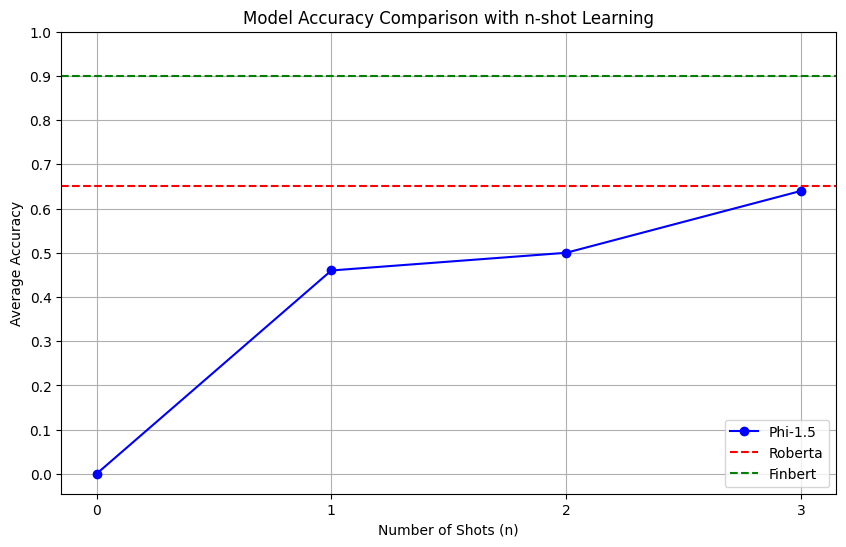

In [ ]:
n_values = [0, 1, 2, 3]  # n-values for Phi-1.5
decoder_accuracies = [
    decoder_zero_results['Average Accuracy'],
    decoder_one_results['Average Accuracy'],
    decoder_two_results['Average Accuracy'],
    decoder_three_results['Average Accuracy']
]
roberta_accuracy = roberta_results['Average Accuracy']
finbert_accuracy = finbert_results['Average Accuracy']

plt.figure(figsize=(10, 6))

# Plot Phi-1.5 accuracies
plt.plot(n_values, decoder_accuracies, marker='o', linestyle='-', label='Phi-1.5', color='b')

plt.axhline(y=roberta_accuracy, color='r', linestyle='--', label='Roberta')
plt.axhline(y=finbert_accuracy, color='g', linestyle='--', label='Finbert')

plt.xlabel('Number of Shots (n)')
plt.ylabel('Average Accuracy')
plt.title('Model Accuracy Comparison with n-shot Learning')
plt.xticks(np.arange(min(n_values), max(n_values)+1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend()

plt.show()


# Evaluation Results and Key Insights:

1. **Finbert's Strength**: Among the encoder models, Finbert substantially outperformed Roberta. This could be due to Finbert's specialized training on financial text, making it particularly well-suited for our dataset.

2. **Adaptability of Decoder Models**: Phi-1.5 performed poorly in a zero-shot setting but showed a remarkable ability to adapt and improve its performance with just a single example (one-shot).

3. **Diminishing Returns**: For Phi-1.5, we observed that adding more examples (two-shot and three-shot) did not significantly improve the performance over the one-shot case.

4. **Specialization vs. Flexibility**: While Finbert showed excellent performance, it's specialized for financial text sentiment analysis. Phi-1.5, on the other hand, demonstrated the capability to adapt to the task with minimal examples.

This showcases the strengths and weaknesses of both encoder and decoder models in a few-shot learning scenario and provides valuable insights into choosing the right model for a NLP task.


# OpenAI API

Let's use OpenAI's GPT-3.5 turbo model to perform the same tasks as the open source HuggingFace models above.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from dotenv import load_dotenv
from os import environ

load_dotenv("/content/drive/MyDrive/CORISE/GENERATING AI WITH OPEN AI/env")
hf_api_token = environ["HUGGINGFACEHUB_API_TOKEN"]
assert sum(hf_api_token.encode('ascii')) == 3505, "HuggingFace key is invalid"
print("HuggingFace key is valid")

openai_api_key = environ["OPENAI_API_KEY"]
assert sum(openai_api_key.encode('ascii')) == 4241, "OpenAI key is invalid"
print("OpenAI key is valid")

openai.api_key = openai_api_key

HuggingFace key is valid
OpenAI key is valid


One can evaluate n-shot prompts directly on OpenAI models chat [online Playgrounds](https://platform.openai.com/playground) as shown below.  

![Image description](https://drive.google.com/uc?export=download&id=1Xu7sEae8Ba9cxFqN8Hdfrz2HGASul8nO)

In [ ]:
from typing import Callable

def create_gpt3_infer(model_name: str = "gpt-3.5-turbo") -> Callable[[str], str]:
    """
    Creates an inference function for a GPT-3.5 Turbo model.

    Args:
        model_name: The name of the GPT-3.5 Turbo model to use for inference.

    Returns:
        A function that takes a sentence as input and returns a predicted label as an integer.
    """

    def gpt3_infer(text: str) -> str:
        """
        Runs inference on a specified GPT-3.5 Turbo model via the OpenAI API
        and classifies the sentiment of a given text.

        The function communicates with the GPT-3.5 Turbo model via the OpenAI API and
        obtains a response based on the input text.

        Args:
            text: The sentence to classify.

        Returns:
            The predicted label as an string, -1 if not negative, neutral, positive
        """
        mission_statement="""You are a financial analyst, expert at determining
                          sentiment and replies with 'negative','neutral' or 'positive'"""
        messages=[{"role": "system", "content": mission_statement},
                  {"role": "user", "content": text}
                 ]

        # inference API call to OpenAI
        response = openai.ChatCompletion.create(
            model=model_name,
            messages=messages,
            temperature=1,
            max_tokens=256,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )

        response_content = response.choices[0].message.content

        sentiment_dict = {'negative':0, 'neutral':1, 'positive':2}
        if response_content not in sentiment_dict:
          response_content = -1

        # process response if it were numbers
        #sentiment = sentiment_dict.get(response_content,-1)

        return response_content

    return gpt3_infer

# Initialize the GPT-3.5 Turbo inference function with a model name
gpt3_infer = create_gpt3_infer("gpt-3.5-turbo")

In [ ]:
text = '''Classify the sentiment (negative, neutral, positive) of the following statement:
        [Finnish meat company Atria can no longer promise a sufficient amount of domestic beef to its customers .]
        Reponse: negative
        [Finnish Raisio ( Diagnostics ) is launching new DNA-based quick tests to ensure the safety of food .]
        Reponse: positive
        [Export declined by 6 percent to 16.4 million liters]
        Reponse: '''

gpt3_infer(text)

0


'negative'

In [ ]:
# @title Unittests
class TestCreateGpt3InferIntegration(unittest.TestCase):

    def test_create_gpt3_infer_example_sentence(self):
        """
        Integration test for create_gpt3_infer using a provided example sentence.
        Calls the API multiple times and takes the plurality result.
        """

        gpt3_infer = create_gpt3_infer("gpt-3.5-turbo")

        # example text
        text = '''Classify the sentiment (negative, neutral, positive) of the following statement:
        [Finnish meat company Atria can no longer promise a sufficient amount of domestic beef to its customers .]
        Reponse: negative
        [Finnish Raisio ( Diagnostics ) is launching new DNA-based quick tests to ensure the safety of food .]
        Reponse: positive
        [Export declined by 6 percent to 16.4 million liters]
        Reponse: '''

        # Run the inference function multiple times
        num_trials = 5
        results = [gpt3_infer(text) for _ in range(num_trials)]

        counter = Counter(results)
        most_common_result, _ = counter.most_common(1)[0]

        self.assertEqual(most_common_result, 'negative')


unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestCreateGpt3InferIntegration))

.
----------------------------------------------------------------------
Ran 1 test in 8.359s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [ ]:
# The network connection slows down these requests, so,
# to save time, let's only look at 20 of the test samples.
# Increase it to get a more precise value for the model's test set accuracy
num_test_samples = 20

In [ ]:
gpt3_0shot_results = evaluate_decoder_inference(gpt3_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 0, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


In [ ]:
gpt3_1shot_results = evaluate_decoder_inference(gpt3_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 1, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


In [ ]:
gpt3_2shot_results = evaluate_decoder_inference(gpt3_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 2, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


In [ ]:
gpt3_3shot_results = evaluate_decoder_inference(gpt3_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 3, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


In [ ]:
# Prepare the ASCII table
header = "| Model Name  | Average Accuracy | Average F1 Score |"
separator = "-" * len(header)

# Print the ASCII table
print(separator)
print(header)
print(separator)
print(f"|GPT-3.5 (n=0)| {gpt3_0shot_results['Average Accuracy']:<16.4f} | {gpt3_0shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 (n=1)| {gpt3_1shot_results['Average Accuracy']:<16.4f} | {gpt3_1shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 (n=2)| {gpt3_2shot_results['Average Accuracy']:<16.4f} | {gpt3_2shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 (n=3)| {gpt3_3shot_results['Average Accuracy']:<16.4f} | {gpt3_3shot_results['Average F1 Score']:<16.4f} |")
print(separator)

-----------------------------------------------------
| Model Name  | Average Accuracy | Average F1 Score |
-----------------------------------------------------
|GPT-3.5 (n=0)| 0.7500           | 0.7500           |
-----------------------------------------------------
|GPT-3.5 (n=1)| 0.8000           | 0.8000           |
-----------------------------------------------------
|GPT-3.5 (n=2)| 0.8500           | 0.8500           |
-----------------------------------------------------
|GPT-3.5 (n=3)| 0.8500           | 0.8500           |
-----------------------------------------------------


In [ ]:
# values from above to avoid re-running everything
roberta_accuracy=0.6515
finbert_accuracy=0.8990
decoder_accuracies = [0.0,0.46,0.5,0.64]
gpt3_base_accuracies = [0.75,0.8,0.85,0.85]

In [ ]:
gpt3_base_accuracies = [
    gpt3_0shot_results['Average Accuracy'],
    gpt3_1shot_results['Average Accuracy'],
    gpt3_2shot_results['Average Accuracy'],
    gpt3_3shot_results['Average Accuracy']
]
print(gpt3_base_accuracies)
roberta_accuracy = roberta_results['Average Accuracy']
finbert_accuracy = finbert_results['Average Accuracy']


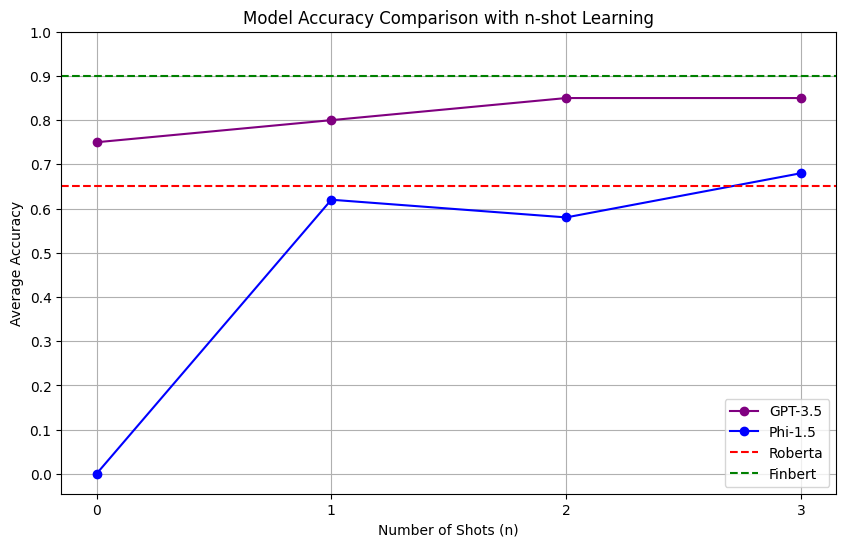

In [ ]:
n_values = [0, 1, 2, 3]  # n-values for GPT-3.5

plt.figure(figsize=(10, 6))

# GPT-3.5 accuracies
plt.plot(n_values, gpt3_base_accuracies, marker='o', linestyle='-', label='GPT-3.5', color='purple')

# Phi-1.5 accuracies
plt.plot(n_values, decoder_accuracies, marker='o', linestyle='-', label='Phi-1.5', color='b')

# Horizontal lines for Roberta and Finbert accuracies
plt.axhline(y=roberta_accuracy, color='r', linestyle='--', label='Roberta')
plt.axhline(y=finbert_accuracy, color='g', linestyle='--', label='Finbert')

plt.xlabel('Number of Shots (n)')
plt.ylabel('Average Accuracy')
plt.title('Model Accuracy Comparison with n-shot Learning')
plt.xticks(np.arange(min(n_values), max(n_values)+1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend()

plt.show()

# Fine-Tuning with GPT-3.5 Turbo

**THIS FINE TUNING WILL COST AROUND $4 IN OPENAI CREDITS**

Let's fine-tune GPT3.5 using the OpenAI API.

We already explored how different models perform on sentiment classification tasks, using both encoder models like Roberta and Finbert as well as decoder models like GPT-3.5 Turbo, as well as the impact of n-shot learning on the performance of these models.  

Now, we're going to take it a step further by fine-tuning GPT-3.5 Turbo on our specific dataset. Fine-tuning adapts a pre-trained model to better perform on a task at hand, potentially increasing its accuracy and F1 score.

[OpenAI's fine-tuning documentation](https://platform.openai.com/docs/guides/fine-tuning) describes the steps to fine-tuning their models.  


## Prepare dataset for OpenAI API
OpenAI accepts fine-tuning data as jsonl files (a json object on each line).  We will prepare such a file with zero-shot examples only, to save on tokens.

In [ ]:
def create_openai_conversation(sample: dict) -> dict:
    """Converts a sample to the OpenAI conversation format.

    Args:
        sample: A dictionary containing 'sentence' and 'label'.

    Returns:
        A dictionary in the OpenAI conversation format.
    """
    return {
        "messages": [
            {"role": "user", "content": sample['sentence']},
            {"role": "assistant", "content": str(sample['label'])}
        ]
    }

def write_training_file_to_disk(samples: iter, filename: str) -> None:
    """Writes the training samples to a file in OpenAI conversation format.

    Args:
        samples: An iterator of samples.
        filename: The name of the file to write the samples to.
    """
    with open(filename, 'w') as f:
        for sample in samples:
            conversation = create_openai_conversation(sample)
            f.write(json.dumps(conversation) + '\n')


sample_count_per_category = 100

file_path = 'train.jsonl'

# Generate the JSONL file
write_training_file_to_disk(phrasebank_split['train'], file_path)

## Initiate Fine Tuning
Now that the training file is ready, it's time to upload the data and then initiate a training job.  Once you have the training job initiated, you can monitor its progress using the openai API like this:

```python
# List the most recent 10 events from a fine-tuning job
openai.FineTuningJob.list_events(id=fine_tune_response['id'], limit=10)
```
Or you can watch the progress using the [OpenAI web portal](https://platform.openai.com/finetune).

**Note that it could take over an hour to fine-tune**

In [ ]:
def initiate_fine_tuning(filename: str, model_name: str) -> dict:
    """Initiates the fine-tuning process with OpenAI.

    Args:
        filename: The name of the training file.
        model_name: The name of the model to be fine-tuned.

    Returns:
        The response from the fine-tuning API call.
    """
    with open(filename, 'rb') as f:
        file_upload = openai.File.create(file=f, purpose='fine-tune')

    fine_tuning_job = openai.FineTuningJob.create(
        training_file=file_upload['id'],
        model=model_name
    )

    return fine_tuning_job

# Initiate fine-tuning
fine_tuning_response = initiate_fine_tuning('train.jsonl', 'gpt-3.5-turbo')
print(f'Fine Tuning job created! (job id: {fine_tuning_response["id"]})') # ftjob-jXH54f6VFQXAebzC7j7spqyt

Fine Tuning job created! (job id: ftjob-jXH54f6VFQXAebzC7j7spqyt)


In [ ]:
# List up to 10 events from a fine-tuning job
openai.FineTuningJob.list_events(id=fine_tuning_response['id'], limit=10)

<OpenAIObject list at 0x79a456bc7830> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-bzm3Q73W2eBdi8BnhrpOdKLV",
      "created_at": 1698078176,
      "level": "info",
      "message": "Step 1201/1636: training loss=0.44",
      "data": {
        "step": 1201,
        "train_loss": 0.4405704438686371,
        "train_mean_token_accuracy": 0.9166666865348816
      },
      "type": "metrics"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-l8xFb8xyy35zYH9hvqInYNwT",
      "created_at": 1698077977,
      "level": "info",
      "message": "Step 1101/1636: training loss=0.04",
      "data": {
        "step": 1101,
        "train_loss": 0.040286142379045486,
        "train_mean_token_accuracy": 1.0
      },
      "type": "metrics"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-OgEON0zgjZwzjAgTcQMbmRo4",
      "created_at": 1698077788,
      "level": "info",
      "message": "Step 

In [ ]:
# Retrieve the state of a fine-tune
openai.FineTuningJob.retrieve(fine_tuning_response['id'])

<FineTuningJob fine_tuning.job id=ftjob-jXH54f6VFQXAebzC7j7spqyt at 0x7ebcd863b600> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-jXH54f6VFQXAebzC7j7spqyt",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1698075549,
  "finished_at": 1698079026,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0613:aitech-engineering::8CsDL6d9",
  "organization_id": "org-87AsGegjNqcX7UfUhfVYWZjK",
  "result_files": [
    "file-t1iASQgZmf78bB26TAgyczAZ"
  ],
  "status": "succeeded",
  "validation_file": null,
  "training_file": "file-WFKvtb6HKFPWJz2yi2NB5LfF",
  "hyperparameters": {
    "n_epochs": 3
  },
  "trained_tokens": 514464,
  "error": null
}

In [ ]:
# Once the fine-tune is complete, we can retrieve the name of the model
status = openai.FineTuningJob.retrieve(fine_tuning_response['id'])
if status['status'] == 'succeeded':
    print('Fine-tuned model name: ' + status['fine_tuned_model'])
    fine_tuned_model = status['fine_tuned_model']
else:
    print('Fine tune not complete!')

Fine-tuned model name: ft:gpt-3.5-turbo-0613:aitech-engineering::8CsDL6d9


In [ ]:
num_test_samples=20

In [ ]:
# Once the model is available, we can use the same inference generator as before!
# All we have to do is add the new model name
gpt3_fine_tune_infer = create_gpt3_infer(fine_tuned_model)

In case Colab cuts GPU access here, these inferences can be done on a cpu.  The first one will take ~50s, and the other 3 ~5s.

In [ ]:
gpt3_fine_tune_0shot_results = evaluate_decoder_inference(gpt3_fine_tune_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 0, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


In [ ]:
gpt3_fine_tune_1shot_results = evaluate_decoder_inference(gpt3_fine_tune_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 1, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


In [ ]:
gpt3_fine_tune_2shot_results = evaluate_decoder_inference(gpt3_fine_tune_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 2, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


In [ ]:
gpt3_fine_tune_3shot_results = evaluate_decoder_inference(gpt3_fine_tune_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 3, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


In [ ]:
# Prepare the ASCII table
header = "|  Model Name    | Average Accuracy | Average F1 Score |"
separator = "-" * len(header)

# Print the ASCII table
print(separator)
print(header)
print(separator)
print(f"|GPT-3.5 FT (n=0)| {gpt3_fine_tune_0shot_results['Average Accuracy']:<16.4f} | {gpt3_fine_tune_0shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 FT (n=1)| {gpt3_fine_tune_1shot_results['Average Accuracy']:<16.4f} | {gpt3_fine_tune_1shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 FT (n=2)| {gpt3_fine_tune_2shot_results['Average Accuracy']:<16.4f} | {gpt3_fine_tune_2shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 FT (n=3)| {gpt3_fine_tune_3shot_results['Average Accuracy']:<16.4f} | {gpt3_fine_tune_3shot_results['Average F1 Score']:<16.4f} |")
print(separator)

--------------------------------------------------------
|  Model Name    | Average Accuracy | Average F1 Score |
--------------------------------------------------------
|GPT-3.5 FT (n=0)| 0.8000           | 0.8000           |
--------------------------------------------------------
|GPT-3.5 FT (n=1)| 0.9000           | 0.9000           |
--------------------------------------------------------
|GPT-3.5 FT (n=2)| 0.8500           | 0.8500           |
--------------------------------------------------------
|GPT-3.5 FT (n=3)| 0.8500           | 0.8500           |
--------------------------------------------------------


In [ ]:
gpt3_finetuned_accuracies = [
    gpt3_fine_tune_0shot_results['Average Accuracy'],
    gpt3_fine_tune_1shot_results['Average Accuracy'],
    gpt3_fine_tune_2shot_results['Average Accuracy'],
    gpt3_fine_tune_3shot_results['Average Accuracy']
]
print(gpt3_finetuned_accuracies)

roberta_accuracy = roberta_results['Average Accuracy']
finbert_accuracy = finbert_results['Average Accuracy']


[0.8, 0.9, 0.85, 0.85]


In [ ]:
roberta_accuracy=0.6515
finbert_accuracy=0.8990
decoder_accuracies = [0.0,0.46,0.5,0.64]
gpt3_base_accuracies = [0.75,0.8,0.85,0.85]
gpt3_finetuned_accuracies = [0.8, 0.9, 0.85, 0.85]


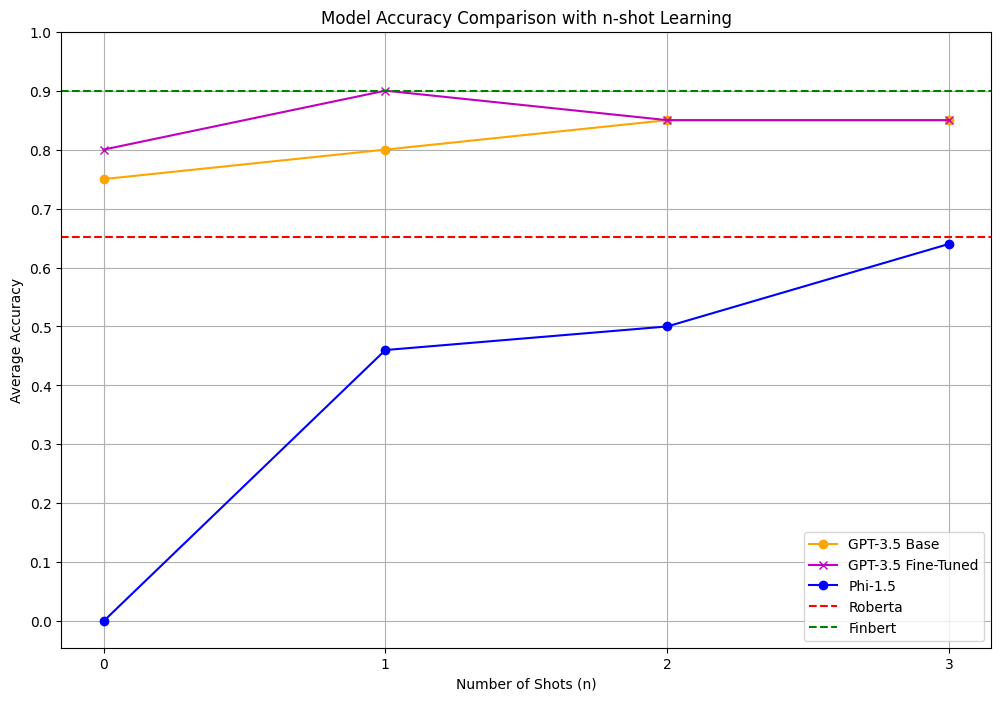

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n_values = [0, 1, 2, 3]  # n-values for GPT-3.5

plt.figure(figsize=(12, 8))

# GPT-3.5 base accuracies
plt.plot(n_values, gpt3_base_accuracies, marker='o', linestyle='-', label='GPT-3.5 Base', color='orange')

# GPT-3.5 fine-tuned accuracies
plt.plot(n_values, gpt3_finetuned_accuracies, marker='x', linestyle='-', label='GPT-3.5 Fine-Tuned', color='m')

# Phi-1.5 accuracies
plt.plot(n_values, decoder_accuracies, marker='o', linestyle='-', label='Phi-1.5', color='b')

# Horizontal lines for Roberta and Finbert
plt.axhline(y=roberta_accuracy, color='r', linestyle='--', label='Roberta')
plt.axhline(y=finbert_accuracy, color='g', linestyle='--', label='Finbert')


plt.xlabel('Number of Shots (n)')
plt.ylabel('Average Accuracy')
plt.title('Model Accuracy Comparison with n-shot Learning')
plt.xticks(np.arange(min(n_values), max(n_values)+1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend()

plt.show()